This Jupyter notebook is a TensorFlow 2 and Keras implementation of the toy example in [TabNAS: Rejection Sampling for Neural Architecture Search on Tabular Datasets](https://arxiv.org/abs/2204.07615) at NeurIPS 2022. 

In [ ]:
import numpy as np
from itertools import product
import multiprocessing as mp
import tensorflow_probability as tfp
import tensorflow as tf
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.patches import Rectangle
from matplotlib.ticker import AutoMinorLocator

In [ ]:
def get_parameter_number(hidden_layer_sizes, input_size=2):
  all_layer_sizes = [input_size] + list(hidden_layer_sizes) + [1]
  num_parameters = int(sum([all_layer_sizes[i] * all_layer_sizes[i+1] + all_layer_sizes[i+1] for i in range(len(all_layer_sizes)-1)]))
  return num_parameters

In [ ]:
layer_1_choices = [2, 3, 4]
layer_2_choices = [2, 3, 4]

In [ ]:
losses = {}
losses[(2, 2)] = 0.9
losses[(2, 3)] = 0.9
losses[(3, 2)] = 0.9
losses[(2, 4)] = 0.66
losses[(4, 2)] = 0.6
losses[(3, 3)] = 0.66
losses[(3, 4)] = 0.3
losses[(4, 3)] = 0.3
losses[(4, 4)] = 0.1

In [ ]:
archs = list(product(layer_1_choices, layer_2_choices))

rewards = {}
for arch in losses:
  rewards[arch] = 1 - losses[arch]

In [ ]:
get_parameter_number([4, 2])  # calculate the number of parameters of 4-2

25

In [ ]:
get_parameter_number([3, 3])  # calculate the number of parameters of 3-3

25

## loss heatmap

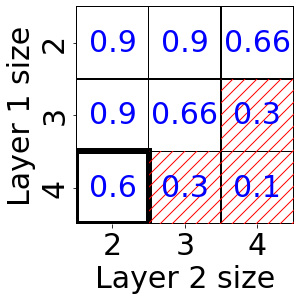

In [ ]:
fontsize = 30
fontsize_annot = 30
losses_2d = np.full((len(layer_1_choices), len(layer_2_choices)), np.nan)
zeros_2d = np.full((len(layer_1_choices), len(layer_2_choices)), 0)
annot_2d = [["" for _ in range(len(layer_2_choices))] for _ in range(len(layer_1_choices))]
edgecolor = 'red'
edge_lw = 6

for index_layer_1, layer_1_choice in enumerate(layer_1_choices):
  for index_layer_2, layer_2_choice in enumerate(layer_2_choices):
    annot_2d[index_layer_1][index_layer_2] = str(losses[(layer_1_choice, layer_2_choice)])

ax = sns.heatmap(zeros_2d, annot=annot_2d, fmt='', linewidth=0.5, square=True, cmap='binary', cbar=False, linewidths=2, linecolor='black', annot_kws={"fontsize": fontsize_annot, "color": "blue"})
ax.figure.axes[-1].yaxis.label.set_size(fontsize)
# ax.xaxis.set_label_position('top')

ax.add_patch(Rectangle((0, 2), 1, 1, fill=False, edgecolor='black', lw=edge_lw))

ax.add_patch(Rectangle((1, 2), 1, 1, hatch=r"//", fill=False, edgecolor=edgecolor, lw=0))
ax.add_patch(Rectangle((2, 1), 1, 1, hatch=r"//", fill=False, edgecolor=edgecolor, lw=0))
ax.add_patch(Rectangle((2, 2), 1, 1, hatch=r"//", fill=False, edgecolor=edgecolor, lw=0))

ax.tick_params(top=False, bottom=True, labeltop=False, labelbottom=True)
ax.set_xticklabels(layer_2_choices, fontsize=fontsize)
ax.set_yticklabels(layer_1_choices, fontsize=fontsize)
plt.xlabel('Layer 2 size', fontsize=fontsize)
plt.ylabel('Layer 1 size', fontsize=fontsize)
filename = 'toy_example_losses_heatmap.png'
plt.savefig(filename, bbox_inches='tight')

# number of parameters heatmap

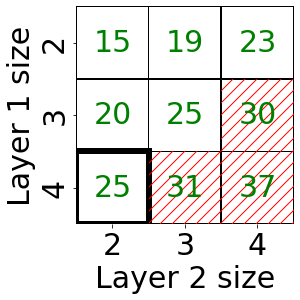

In [ ]:
fontsize = 30
fontsize_annot = 30
losses_2d = np.full((len(layer_1_choices), len(layer_2_choices)), np.nan)
zeros_2d = np.full((len(layer_1_choices), len(layer_2_choices)), 0)
# annot_2d = np.full((len(layer_1_choices), len(layer_2_choices)), "")
annot_2d = [["" for _ in range(len(layer_2_choices))] for _ in range(len(layer_1_choices))]
# edgecolor = 'cyan'
edgecolor = 'red'
edge_lw = 6

for index_layer_1, layer_1_choice in enumerate(layer_1_choices):
  for index_layer_2, layer_2_choice in enumerate(layer_2_choices):
    annot_2d[index_layer_1][index_layer_2] = str(get_parameter_number([layer_1_choice, layer_2_choice]))

ax = sns.heatmap(zeros_2d, annot=annot_2d, fmt='', linewidth=0.5, square=True, cmap='binary', cbar=False, linewidths=2, linecolor='black', annot_kws={"fontsize": fontsize_annot, "color": "green"})
ax.figure.axes[-1].yaxis.label.set_size(fontsize)
# ax.xaxis.set_label_position('top')

ax.add_patch(Rectangle((0, 2), 1, 1, fill=False, edgecolor='black', lw=edge_lw))

ax.add_patch(Rectangle((1, 2), 1, 1, hatch=r"//", fill=False, edgecolor=edgecolor, lw=0))
ax.add_patch(Rectangle((2, 1), 1, 1, hatch=r"//", fill=False, edgecolor=edgecolor, lw=0))
ax.add_patch(Rectangle((2, 2), 1, 1, hatch=r"//", fill=False, edgecolor=edgecolor, lw=0))

ax.tick_params(top=False, bottom=True, labeltop=False, labelbottom=True)
ax.set_xticklabels(layer_2_choices, fontsize=fontsize)
ax.set_yticklabels(layer_1_choices, fontsize=fontsize)
plt.xlabel('Layer 2 size', fontsize=fontsize)
plt.ylabel('Layer 1 size', fontsize=fontsize)
filename = 'toy_example_nparams_heatmap.png'
plt.savefig(filename, bbox_inches='tight')

# RL with the resource-aware Abs Reward

In [ ]:
# list of tuples of feasible indices
feasible_indices = [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (2, 0)]

In [ ]:
# hyperparameters
beta = 1
rl_learning_rate = 0.05
max_iter = 500
optimizer_name = 'adam'

if optimizer_name == 'adam':
  optimizer = tf.keras.optimizers.Adam(learning_rate=rl_learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-8)

def run_abs(i_rep):
  """
  Runs RL-based NAS with the Abs Reward, starting from uniform distribution.

  Args:

  i_rep (int): the repetition index.

  Returns:

  layer_1_probs_all (dict): sampling probabilities of the first layer.
  layer_1_probs_all (dict): sampling probabilities of the second layer.
  """
  layer_1_probs_all = {} # key: number of steps
  layer_2_probs_all = {} # key: number of steps

  layer_1_logits = tf.Variable(tf.constant([0 for _ in range(len(layer_1_choices))], dtype=float))
  layer_2_logits = tf.Variable(tf.constant([0 for _ in range(len(layer_2_choices))], dtype=float))

  rl_reward_momentum = 0.9
  moving_average_baseline_numer = 0
  moving_average_baseline_denom = 0

  rl_advantage_all = []
  prob_valid_all = []

  for iter in range(max_iter):
    tf.random.set_seed(1000 * i_rep + iter)
    layer_1_dist = tfp.distributions.Categorical(logits=layer_1_logits)
    layer_1_probs = layer_1_dist.probs_parameter().numpy()
    index_layer_1_choice = layer_1_dist.sample().numpy()
    layer_1_choice = layer_1_choices[index_layer_1_choice]
    layer_2_dist = tfp.distributions.Categorical(logits=layer_2_logits)
    layer_2_probs = layer_2_dist.probs_parameter().numpy()
    index_layer_2_choice = layer_2_dist.sample().numpy()
    layer_2_choice = layer_2_choices[index_layer_2_choice]
    
    layer_1_probs_all[iter] = layer_1_probs
    layer_2_probs_all[iter] = layer_2_probs

    # compute single-step RL advantage
    rl_reward = rewards[(layer_1_choice, layer_2_choice)] - beta * np.abs(get_parameter_number([layer_1_choice, layer_2_choice]) / get_parameter_number([3, 3]) - 1)
    moving_average_baseline_numer = rl_reward_momentum * moving_average_baseline_numer + (1 - rl_reward_momentum) * rl_reward
    moving_average_baseline_denom = rl_reward_momentum * moving_average_baseline_denom + 1 - rl_reward_momentum
    moving_average_baseline = moving_average_baseline_numer / moving_average_baseline_denom
    rl_advantage = rl_reward - moving_average_baseline 
    rl_advantage_all.append(rl_advantage)

    layer_1_logits_tf = layer_1_dist.logits
    layer_2_logits_tf = layer_2_dist.logits

    # policy gradient via REINFORCE
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(layer_1_logits_tf)
        tape.watch(layer_2_logits_tf)
        layer_1_probs_tf = tf.nn.softmax(layer_1_logits_tf)
        layer_2_probs_tf = tf.nn.softmax(layer_2_logits_tf)
        sampling_prob = layer_1_probs_tf[index_layer_1_choice] * layer_2_probs_tf[index_layer_2_choice]
        log_sampling_prob = tf.math.log(sampling_prob)
        negative_value_function = - rl_advantage * log_sampling_prob

    grad_layer_1 = tape.gradient(negative_value_function, layer_1_logits_tf)
    grad_layer_2 = tape.gradient(negative_value_function, layer_2_logits_tf)

    optimizer.apply_gradients(zip([grad_layer_1, grad_layer_2], [layer_1_logits, layer_2_logits]))

  layer_1_dist = tfp.distributions.Categorical(logits=layer_1_logits)
  layer_1_probs = layer_1_dist.probs_parameter().numpy()
  layer_2_dist = tfp.distributions.Categorical(logits=layer_2_logits)
  layer_2_probs = layer_2_dist.probs_parameter().numpy()
  layer_1_probs_all[max_iter] = layer_1_probs
  layer_2_probs_all[max_iter] = layer_2_probs

  return layer_1_probs_all, layer_2_probs_all

In [ ]:
n_reps = 20  # for easier demonstration; was 500 in paper
n_cpus = mp.cpu_count()
p = mp.Pool(n_cpus)
mp_results = [p.apply_async(run_abs, args=[i_rep]) for i_rep in range(n_reps)]
r = [f.get() for f in mp_results]

layer_1_probs_all_in_all_reps = {}
layer_2_probs_all_in_all_reps = {}

for i_rep, item in enumerate(r):
  layer_1_probs_all_in_all_reps[i_rep] = item[0]
  layer_2_probs_all_in_all_reps[i_rep] = item[1]

In [ ]:
sampling_probs_all_layer_1 = np.full((len(layer_1_choices), max_iter+1), np.nan)
sampling_probs_all_layer_2 = np.full((len(layer_1_choices), max_iter+1), np.nan)

for i_choice, choice in enumerate(layer_1_choices):
  layer_1_multiple_reps = np.vstack([np.array([layer_1_probs_all_in_all_reps[i_rep][iter][i_choice] for iter in range(max_iter+1)]) for i_rep in range(n_reps)])
  layer_1_multiple_reps_mean = np.average(layer_1_multiple_reps, axis=0)
  sampling_probs_all_layer_1[i_choice] = layer_1_multiple_reps_mean

for i_choice, choice in enumerate(layer_2_choices):
  layer_2_multiple_reps = np.vstack([np.array([layer_2_probs_all_in_all_reps[i_rep][iter][i_choice] for iter in range(max_iter+1)]) for i_rep in range(n_reps)])
  layer_2_multiple_reps_mean = np.average(layer_2_multiple_reps, axis=0)
  sampling_probs_all_layer_2[i_choice] = layer_2_multiple_reps_mean

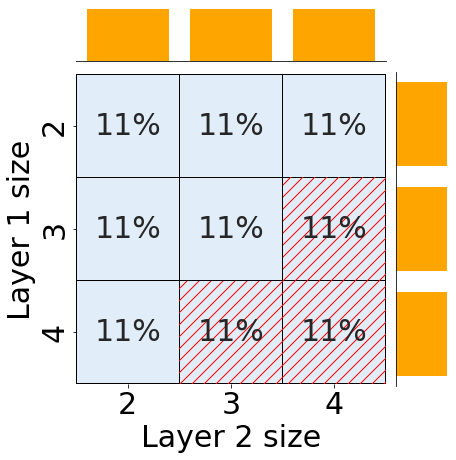

In [ ]:
iteration = 0

fontsize = 30
fontsize_annot = 30

sampling_probs_all_choices_autoflow_start = np.array([np.prod(item) for item in list(product(sampling_probs_all_layer_1[:, iteration], sampling_probs_all_layer_2[:, iteration]))]).reshape(3, 3)

data = pd.DataFrame({'Layer 2 size': sampling_probs_all_layer_2[:, iteration],
                     'Layer 1 size': sampling_probs_all_layer_1[:, iteration],
                     })
g = sns.jointplot(data=data, x="Layer 2 size", y="Layer 1 size")
g.ax_marg_y.cla()
g.ax_marg_x.cla()

annot_2d = [["" for _ in range(len(layer_2_choices))] for _ in range(len(layer_1_choices))]

for index_layer_1, layer_1_choice in enumerate(layer_1_choices):
  for index_layer_2, layer_2_choice in enumerate(layer_2_choices):
    annot_2d[index_layer_1][index_layer_2] = "{:.0%}".format(np.around(sampling_probs_all_choices_autoflow_start, 2)[index_layer_1][index_layer_2])

sns.heatmap(sampling_probs_all_choices_autoflow_start, annot=annot_2d, fmt='', linewidth=0.5, 
            ax=g.ax_joint, square=True, cmap='Blues', cbar=False, linewidths=2, linecolor='black', annot_kws={"fontsize": fontsize_annot}, vmin=0, vmax=1)
g.ax_joint.add_patch(Rectangle((1, 2), 1, 1, hatch=r"//", fill=False, edgecolor=edgecolor, lw=0))
g.ax_joint.add_patch(Rectangle((2, 1), 1, 1, hatch=r"//", fill=False, edgecolor=edgecolor, lw=0))
g.ax_joint.add_patch(Rectangle((2, 2), 1, 1, hatch=r"//", fill=False, edgecolor=edgecolor, lw=0))

g.ax_marg_y.barh(np.arange(0.5, len(layer_1_choices)), sampling_probs_all_layer_1[:, iteration], color='orange')
g.ax_marg_x.bar(np.arange(0.5, len(layer_2_choices)), sampling_probs_all_layer_2[:, iteration], color='orange')

g.ax_marg_x.tick_params(axis='x', bottom=False, labelbottom=False)
g.ax_marg_y.tick_params(axis='y', left=False, labelleft=False)
g.ax_marg_x.tick_params(axis='y', left=False, labelleft=False)
g.ax_marg_y.tick_params(axis='x', bottom=False, labelbottom=False)

g.ax_joint.set_xticks(np.arange(0.5, len(layer_2_choices)))
g.ax_joint.set_xticklabels(layer_2_choices, fontsize=fontsize)
g.ax_joint.set_yticks(np.arange(0.5, len(layer_1_choices)))
g.ax_joint.set_yticklabels(layer_1_choices, fontsize=fontsize)

g.ax_joint.set_xlabel('Layer 2 size', fontsize=fontsize)
g.ax_joint.set_ylabel('Layer 1 size', fontsize=fontsize)

filename = 'toy_example_autoflow_sampling_prob_heatmap_lr_{}_beta_{}_{}_start.png'.format(rl_learning_rate, beta, optimizer_name)
plt.savefig(filename, bbox_inches='tight')

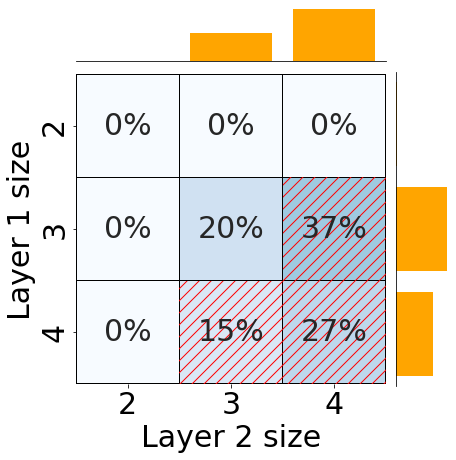

In [ ]:
iteration = 250

fontsize = 30
fontsize_annot = 30

sampling_probs_all_choices_autoflow_middle = np.array([np.prod(item) for item in list(product(sampling_probs_all_layer_1[:, iteration], sampling_probs_all_layer_2[:, iteration]))]).reshape(3, 3)

data = pd.DataFrame({'Layer 2 size': sampling_probs_all_layer_2[:, iteration],
                     'Layer 1 size': sampling_probs_all_layer_1[:, iteration],
                     })
g = sns.jointplot(data=data, x="Layer 2 size", y="Layer 1 size")
g.ax_marg_y.cla()
g.ax_marg_x.cla()

annot_2d = [["" for _ in range(len(layer_2_choices))] for _ in range(len(layer_1_choices))]

for index_layer_1, layer_1_choice in enumerate(layer_1_choices):
  for index_layer_2, layer_2_choice in enumerate(layer_2_choices):
    annot_2d[index_layer_1][index_layer_2] = "{:.0%}".format(np.around(sampling_probs_all_choices_autoflow_middle, 2)[index_layer_1][index_layer_2])

sns.heatmap(sampling_probs_all_choices_autoflow_middle, annot=annot_2d, fmt='', linewidth=0.5, 
            ax=g.ax_joint, square=True, cmap='Blues', cbar=False, linewidths=2, linecolor='black', annot_kws={"fontsize": fontsize_annot}, vmin=0, vmax=1)
g.ax_joint.add_patch(Rectangle((1, 2), 1, 1, hatch=r"//", fill=False, edgecolor=edgecolor, lw=0))
g.ax_joint.add_patch(Rectangle((2, 1), 1, 1, hatch=r"//", fill=False, edgecolor=edgecolor, lw=0))
g.ax_joint.add_patch(Rectangle((2, 2), 1, 1, hatch=r"//", fill=False, edgecolor=edgecolor, lw=0))

g.ax_marg_y.barh(np.arange(0.5, len(layer_1_choices)), sampling_probs_all_layer_1[:, iteration], color='orange')
g.ax_marg_x.bar(np.arange(0.5, len(layer_2_choices)), sampling_probs_all_layer_2[:, iteration], color='orange')

g.ax_marg_x.tick_params(axis='x', bottom=False, labelbottom=False)
g.ax_marg_y.tick_params(axis='y', left=False, labelleft=False)
g.ax_marg_x.tick_params(axis='y', left=False, labelleft=False)
g.ax_marg_y.tick_params(axis='x', bottom=False, labelbottom=False)

g.ax_joint.set_xticks(np.arange(0.5, len(layer_2_choices)))
g.ax_joint.set_xticklabels(layer_2_choices, fontsize=fontsize)
g.ax_joint.set_yticks(np.arange(0.5, len(layer_1_choices)))
g.ax_joint.set_yticklabels(layer_1_choices, fontsize=fontsize)

g.ax_joint.set_xlabel('Layer 2 size', fontsize=fontsize)
g.ax_joint.set_ylabel('Layer 1 size', fontsize=fontsize)

filename = 'toy_example_autoflow_sampling_prob_heatmap_lr_{}_beta_{}_{}_middle.png'.format(rl_learning_rate, beta, optimizer_name)
plt.savefig(filename, bbox_inches='tight')

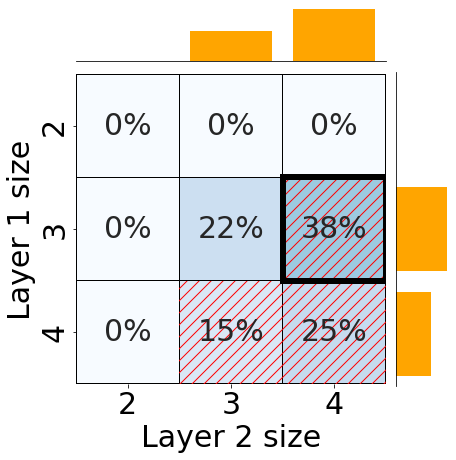

In [ ]:
iteration = -1 # last iteration

fontsize = 30
fontsize_annot = 30

sampling_probs_all_choices_autoflow_end = np.array([np.prod(item) for item in list(product(sampling_probs_all_layer_1[:, iteration], sampling_probs_all_layer_2[:, iteration]))]).reshape(3, 3)

data = pd.DataFrame({'Layer 2 size': sampling_probs_all_layer_2[:, iteration],
                     'Layer 1 size': sampling_probs_all_layer_1[:, iteration],
                     })
g = sns.jointplot(data=data, x="Layer 2 size", y="Layer 1 size")
g.ax_marg_y.cla()
g.ax_marg_x.cla()

annot_2d = [["" for _ in range(len(layer_2_choices))] for _ in range(len(layer_1_choices))]

for index_layer_1, layer_1_choice in enumerate(layer_1_choices):
  for index_layer_2, layer_2_choice in enumerate(layer_2_choices):
    annot_2d[index_layer_1][index_layer_2] = "{:.0%}".format(np.around(sampling_probs_all_choices_autoflow_end, 2)[index_layer_1][index_layer_2])

sns.heatmap(sampling_probs_all_choices_autoflow_end, annot=annot_2d, fmt='', linewidth=0.5, 
            ax=g.ax_joint, square=True, cmap='Blues', cbar=False, linewidths=2, linecolor='black', annot_kws={"fontsize": fontsize_annot}, vmin=0, vmax=1)
g.ax_joint.add_patch(Rectangle((1, 2), 1, 1, hatch=r"//", fill=False, edgecolor=edgecolor, lw=0))
g.ax_joint.add_patch(Rectangle((2, 1), 1, 1, hatch=r"//", fill=False, edgecolor=edgecolor, lw=0))
g.ax_joint.add_patch(Rectangle((2, 2), 1, 1, hatch=r"//", fill=False, edgecolor=edgecolor, lw=0))

g.ax_marg_y.barh(np.arange(0.5, len(layer_1_choices)), sampling_probs_all_layer_1[:, iteration], color='orange')
g.ax_marg_x.bar(np.arange(0.5, len(layer_2_choices)), sampling_probs_all_layer_2[:, iteration], color='orange')

g.ax_joint.add_patch(Rectangle(np.unravel_index(np.argmax(np.around(sampling_probs_all_choices_autoflow_end, 2)), (len(layer_1_choices), len(layer_2_choices)))[::-1], 
                               1, 1, fill=False, edgecolor='black', lw=edge_lw))

g.ax_marg_x.tick_params(axis='x', bottom=False, labelbottom=False)
g.ax_marg_y.tick_params(axis='y', left=False, labelleft=False)
g.ax_marg_x.tick_params(axis='y', left=False, labelleft=False)
g.ax_marg_y.tick_params(axis='x', bottom=False, labelbottom=False)

g.ax_joint.set_xticks(np.arange(0.5, len(layer_2_choices)))
g.ax_joint.set_xticklabels(layer_2_choices, fontsize=fontsize)
g.ax_joint.set_yticks(np.arange(0.5, len(layer_1_choices)))
g.ax_joint.set_yticklabels(layer_1_choices, fontsize=fontsize)

g.ax_joint.set_xlabel('Layer 2 size', fontsize=fontsize)
g.ax_joint.set_ylabel('Layer 1 size', fontsize=fontsize)

filename = 'toy_example_autoflow_sampling_prob_heatmap_lr_{}_beta_{}_{}_end.png'.format(rl_learning_rate, beta, optimizer_name)
plt.savefig(filename, bbox_inches='tight')

# With rejection-based TabNAS reward

In [ ]:
# list of tuples of feasible indices
feasible_indices = [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (2, 0)]

In [ ]:
# hyperparameters
optimizer_name = 'adam'
num_samples_for_mc_start = 5
num_samples_for_mc_end = 5
rl_learning_rate = 0.1
max_iter = 500

def run_sampling(i_rep):
  """
  Runs RL-based NAS with the rejection-based reward (TabNAS), starting from uniform distribution.

  Args:

  i_rep (int): the repetition index.

  Returns:

  layer_1_probs_all (dict): sampling probabilities of the first layer.
  layer_1_probs_all (dict): sampling probabilities of the second layer.
  """
  if optimizer_name == 'adam':
    optimizer = tf.keras.optimizers.Adam(learning_rate=rl_learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-8)

  layer_1_probs_all = {} # key: number of steps
  layer_2_probs_all = {} # key: number of steps

  layer_1_logits = tf.Variable(tf.constant([0 for _ in range(len(layer_1_choices))], dtype=float))
  layer_2_logits = tf.Variable(tf.constant([0 for _ in range(len(layer_2_choices))], dtype=float))

  rl_reward_momentum = 0.9
  moving_average_baseline_numer = 0
  moving_average_baseline_denom = 0

  rl_advantage_all = []
  prob_valid_all = []

  for iter in range(max_iter):
    tf.random.set_seed(1000 * i_rep + iter)
    num_samples_for_mc = (max_iter - iter) / max_iter * (num_samples_for_mc_start - num_samples_for_mc_end) + num_samples_for_mc_end
    num_samples_for_mc = int(np.ceil(num_samples_for_mc))

    layer_1_dist = tfp.distributions.Categorical(logits=layer_1_logits)
    layer_1_probs = layer_1_dist.probs_parameter().numpy()
    index_layer_1_choice = layer_1_dist.sample().numpy()
    layer_1_choice = layer_1_choices[index_layer_1_choice]
    layer_2_dist = tfp.distributions.Categorical(logits=layer_2_logits)
    layer_2_probs = layer_2_dist.probs_parameter().numpy()
    index_layer_2_choice = layer_2_dist.sample().numpy()
    layer_2_choice = layer_2_choices[index_layer_2_choice]
    if (index_layer_1_choice, index_layer_2_choice) not in feasible_indices:
      layer_1_probs_all[iter] = layer_1_probs
      layer_2_probs_all[iter] = layer_2_probs
      continue
    
    layer_1_probs_all[iter] = layer_1_probs
    layer_2_probs_all[iter] = layer_2_probs

    # compute single-step RL advantage
    moving_average_baseline_numer = rl_reward_momentum * moving_average_baseline_numer + (1 - rl_reward_momentum) * rewards[(layer_1_choice, layer_2_choice)]
    moving_average_baseline_denom = rl_reward_momentum * moving_average_baseline_denom + 1 - rl_reward_momentum
    moving_average_baseline = moving_average_baseline_numer / moving_average_baseline_denom
    rl_advantage = rewards[(layer_1_choice, layer_2_choice)] - moving_average_baseline
    rl_advantage_all.append(rl_advantage)

    layer_1_logits_tf = layer_1_dist.logits
    layer_2_logits_tf = layer_2_dist.logits

    # policy gradient via REINFORCE
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(layer_1_logits_tf)
        tape.watch(layer_2_logits_tf)
        layer_1_probs_tf = tf.nn.softmax(layer_1_logits_tf)
        layer_2_probs_tf = tf.nn.softmax(layer_2_logits_tf)
        index_layer_1_samples_for_mc = tf.cast(layer_1_dist.sample(num_samples_for_mc), tf.int64).numpy()
        index_layer_2_samples_for_mc = tf.cast(layer_2_dist.sample(num_samples_for_mc), tf.int64).numpy()
        sampled_feasible_choices = [(index_layer_1_single, index_layer_2_single) for index_layer_1_single, index_layer_2_single in zip(index_layer_1_samples_for_mc, index_layer_2_samples_for_mc) \
                                    if (index_layer_1_single, index_layer_2_single) in feasible_indices]
        if len(sampled_feasible_choices) == 0:
          continue
        estimated_prob_valid = tf.reduce_sum([layer_1_probs_tf[i] * layer_2_probs_tf[j] for i, j in sampled_feasible_choices])
        conditional_prob = layer_1_probs_tf[index_layer_1_choice] * layer_2_probs_tf[index_layer_2_choice] / estimated_prob_valid
        log_conditional_prob = tf.math.log(conditional_prob)
        negative_value_function = - rl_advantage * log_conditional_prob

    grad_layer_1 = tape.gradient(negative_value_function, layer_1_logits_tf)
    grad_layer_2 = tape.gradient(negative_value_function, layer_2_logits_tf)

    optimizer.apply_gradients(zip([grad_layer_1, grad_layer_2], [layer_1_logits, layer_2_logits]))


  layer_1_dist = tfp.distributions.Categorical(logits=layer_1_logits)
  layer_1_probs = layer_1_dist.probs_parameter().numpy()
  layer_2_dist = tfp.distributions.Categorical(logits=layer_2_logits)
  layer_2_probs = layer_2_dist.probs_parameter().numpy()
  layer_1_probs_all[max_iter] = layer_1_probs
  layer_2_probs_all[max_iter] = layer_2_probs

  return layer_1_probs_all, layer_2_probs_all

In [ ]:
n_reps = 20  # for easier demonstration; was 500 in paper
n_cpus = mp.cpu_count()
p = mp.Pool(n_cpus)
mp_results = [p.apply_async(run_sampling, args=[i_rep]) for i_rep in range(n_reps)]
r = [f.get() for f in mp_results]

layer_1_probs_all_in_all_reps = {}
layer_2_probs_all_in_all_reps = {}

for i_rep, item in enumerate(r):
  layer_1_probs_all_in_all_reps[i_rep] = item[0]
  layer_2_probs_all_in_all_reps[i_rep] = item[1]

In [ ]:
sampling_probs_all_layer_1 = np.full((len(layer_1_choices), max_iter+1), np.nan)
sampling_probs_all_layer_2 = np.full((len(layer_1_choices), max_iter+1), np.nan)

for i_choice, choice in enumerate(layer_1_choices):
  layer_1_multiple_reps = np.vstack([np.array([layer_1_probs_all_in_all_reps[i_rep][iter][i_choice] for iter in range(max_iter+1)]) for i_rep in range(n_reps)])
  layer_1_multiple_reps_mean = np.average(layer_1_multiple_reps, axis=0)
  sampling_probs_all_layer_1[i_choice] = layer_1_multiple_reps_mean

for i_choice, choice in enumerate(layer_2_choices):
  layer_2_multiple_reps = np.vstack([np.array([layer_2_probs_all_in_all_reps[i_rep][iter][i_choice] for iter in range(max_iter+1)]) for i_rep in range(n_reps)])
  layer_2_multiple_reps_mean = np.average(layer_2_multiple_reps, axis=0)
  sampling_probs_all_layer_2[i_choice] = layer_2_multiple_reps_mean

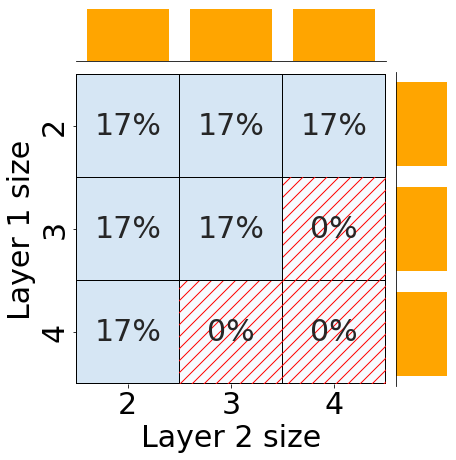

In [ ]:
iteration = 0

fontsize = 30
fontsize_annot = 30

unconditional_sampling_probs_all_choices_rejection_start = np.full((len(layer_1_choices), len(layer_2_choices)), np.nan)
feasible_prob = 0
for i_layer_1_choice, layer_1_choice in enumerate(layer_1_choices):
  for i_layer_2_choice, layer_2_choice in enumerate(layer_2_choices):
    if (i_layer_1_choice, i_layer_2_choice) in feasible_indices:
      unconditional_sampling_probs_all_choices_rejection_start[i_layer_1_choice, i_layer_2_choice] = sampling_probs_all_layer_1[i_layer_1_choice, iteration] * sampling_probs_all_layer_2[i_layer_2_choice, iteration]
      feasible_prob += unconditional_sampling_probs_all_choices_rejection_start[i_layer_1_choice, i_layer_2_choice]

sampling_probs_all_choices_rejection_start = np.full((len(layer_1_choices), len(layer_2_choices)), np.nan)
for i_layer_1_choice, layer_1_choice in enumerate(layer_1_choices):
  for i_layer_2_choice, layer_2_choice in enumerate(layer_2_choices):
    if (i_layer_1_choice, i_layer_2_choice) in feasible_indices:
      sampling_probs_all_choices_rejection_start[i_layer_1_choice, i_layer_2_choice] = unconditional_sampling_probs_all_choices_rejection_start[i_layer_1_choice, i_layer_2_choice] / feasible_prob
    else:
      sampling_probs_all_choices_rejection_start[i_layer_1_choice, i_layer_2_choice] = 0

data = pd.DataFrame({'Layer 2 size': sampling_probs_all_layer_2[:, iteration],
                     'Layer 1 size': sampling_probs_all_layer_1[:, iteration],
                     })
g = sns.jointplot(data=data, x="Layer 2 size", y="Layer 1 size")
g.ax_marg_y.cla()
g.ax_marg_x.cla()

annot_2d = [["" for _ in range(len(layer_2_choices))] for _ in range(len(layer_1_choices))]

for index_layer_1, layer_1_choice in enumerate(layer_1_choices):
  for index_layer_2, layer_2_choice in enumerate(layer_2_choices):
    annot_2d[index_layer_1][index_layer_2] = "{:.0%}".format(np.around(sampling_probs_all_choices_rejection_start, 2)[index_layer_1][index_layer_2])

sns.heatmap(sampling_probs_all_choices_rejection_start, annot=annot_2d, fmt='', linewidth=0.5, 
            ax=g.ax_joint, square=True, cmap='Blues', cbar=False, linewidths=2, linecolor='black', annot_kws={"fontsize": fontsize_annot}, vmin=0, vmax=1)
g.ax_joint.add_patch(Rectangle((1, 2), 1, 1, hatch=r"//", fill=False, edgecolor=edgecolor, lw=0))
g.ax_joint.add_patch(Rectangle((2, 1), 1, 1, hatch=r"//", fill=False, edgecolor=edgecolor, lw=0))
g.ax_joint.add_patch(Rectangle((2, 2), 1, 1, hatch=r"//", fill=False, edgecolor=edgecolor, lw=0))

g.ax_marg_y.barh(np.arange(0.5, len(layer_1_choices)), sampling_probs_all_layer_1[:, iteration], color='orange')
g.ax_marg_x.bar(np.arange(0.5, len(layer_2_choices)), sampling_probs_all_layer_2[:, iteration], color='orange')

g.ax_marg_x.tick_params(axis='x', bottom=False, labelbottom=False)
g.ax_marg_y.tick_params(axis='y', left=False, labelleft=False)
g.ax_marg_x.tick_params(axis='y', left=False, labelleft=False)
g.ax_marg_y.tick_params(axis='x', bottom=False, labelbottom=False)

g.ax_joint.set_xticks(np.arange(0.5, len(layer_2_choices)))
g.ax_joint.set_xticklabels(layer_2_choices, fontsize=fontsize)
g.ax_joint.set_yticks(np.arange(0.5, len(layer_1_choices)))
g.ax_joint.set_yticklabels(layer_1_choices, fontsize=fontsize)

g.ax_joint.set_xlabel('Layer 2 size', fontsize=fontsize)
g.ax_joint.set_ylabel('Layer 1 size', fontsize=fontsize)

filename = 'toy_example_mc_pvalid_sampling_prob_heatmap_lr_{}_{}_start.png'.format(rl_learning_rate, optimizer_name)
plt.savefig(filename, bbox_inches='tight')

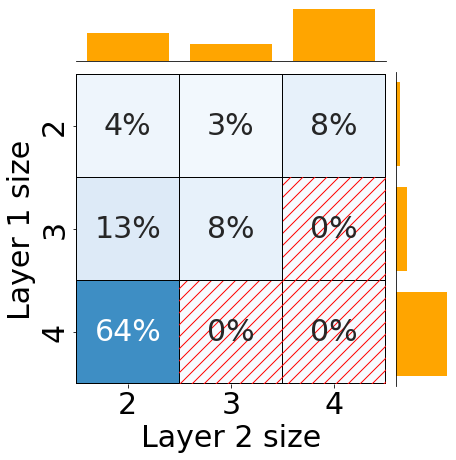

In [ ]:
iteration = 250

fontsize = 30
fontsize_annot = 30

unconditional_sampling_probs_all_choices_rejection_middle = np.full((len(layer_1_choices), len(layer_2_choices)), np.nan)
feasible_prob = 0
for i_layer_1_choice, layer_1_choice in enumerate(layer_1_choices):
 for i_layer_2_choice, layer_2_choice in enumerate(layer_2_choices):
   if (i_layer_1_choice, i_layer_2_choice) in feasible_indices:
     unconditional_sampling_probs_all_choices_rejection_middle[i_layer_1_choice, i_layer_2_choice] = sampling_probs_all_layer_1[i_layer_1_choice, iteration] * sampling_probs_all_layer_2[i_layer_2_choice, iteration]
     feasible_prob += unconditional_sampling_probs_all_choices_rejection_middle[i_layer_1_choice, i_layer_2_choice]
 
sampling_probs_all_choices_rejection_middle = np.full((len(layer_1_choices), len(layer_2_choices)), np.nan)
for i_layer_1_choice, layer_1_choice in enumerate(layer_1_choices):
 for i_layer_2_choice, layer_2_choice in enumerate(layer_2_choices):
   if (i_layer_1_choice, i_layer_2_choice) in feasible_indices:
     sampling_probs_all_choices_rejection_middle[i_layer_1_choice, i_layer_2_choice] = unconditional_sampling_probs_all_choices_rejection_middle[i_layer_1_choice, i_layer_2_choice] / feasible_prob
   else:
     sampling_probs_all_choices_rejection_middle[i_layer_1_choice, i_layer_2_choice] = 0

data = pd.DataFrame({'Layer 2 size': sampling_probs_all_layer_2[:, iteration],
                     'Layer 1 size': sampling_probs_all_layer_1[:, iteration],
                     })
g = sns.jointplot(data=data, x="Layer 2 size", y="Layer 1 size")
g.ax_marg_y.cla()
g.ax_marg_x.cla()

annot_2d = [["" for _ in range(len(layer_2_choices))] for _ in range(len(layer_1_choices))]

for index_layer_1, layer_1_choice in enumerate(layer_1_choices):
  for index_layer_2, layer_2_choice in enumerate(layer_2_choices):
    annot_2d[index_layer_1][index_layer_2] = "{:.0%}".format(np.around(sampling_probs_all_choices_rejection_middle, 2)[index_layer_1][index_layer_2])

sns.heatmap(sampling_probs_all_choices_rejection_middle, annot=annot_2d, fmt='', linewidth=0.5, 
            ax=g.ax_joint, square=True, cmap='Blues', cbar=False, linewidths=2, linecolor='black', annot_kws={"fontsize": fontsize_annot}, vmin=0, vmax=1)
g.ax_joint.add_patch(Rectangle((1, 2), 1, 1, hatch=r"//", fill=False, edgecolor=edgecolor, lw=0))
g.ax_joint.add_patch(Rectangle((2, 1), 1, 1, hatch=r"//", fill=False, edgecolor=edgecolor, lw=0))
g.ax_joint.add_patch(Rectangle((2, 2), 1, 1, hatch=r"//", fill=False, edgecolor=edgecolor, lw=0))

g.ax_marg_y.barh(np.arange(0.5, len(layer_1_choices)), sampling_probs_all_layer_1[:, iteration], color='orange')
g.ax_marg_x.bar(np.arange(0.5, len(layer_2_choices)), sampling_probs_all_layer_2[:, iteration], color='orange')

g.ax_marg_x.tick_params(axis='x', bottom=False, labelbottom=False)
g.ax_marg_y.tick_params(axis='y', left=False, labelleft=False)
g.ax_marg_x.tick_params(axis='y', left=False, labelleft=False)
g.ax_marg_y.tick_params(axis='x', bottom=False, labelbottom=False)

g.ax_joint.set_xticks(np.arange(0.5, len(layer_2_choices)))
g.ax_joint.set_xticklabels(layer_2_choices, fontsize=fontsize)
g.ax_joint.set_yticks(np.arange(0.5, len(layer_1_choices)))
g.ax_joint.set_yticklabels(layer_1_choices, fontsize=fontsize)

g.ax_joint.set_xlabel('Layer 2 size', fontsize=fontsize)
g.ax_joint.set_ylabel('Layer 1 size', fontsize=fontsize)

filename = 'toy_example_mc_pvalid_sampling_prob_heatmap_lr_{}_{}_middle.png'.format(rl_learning_rate, optimizer_name)
plt.savefig(filename, bbox_inches='tight')

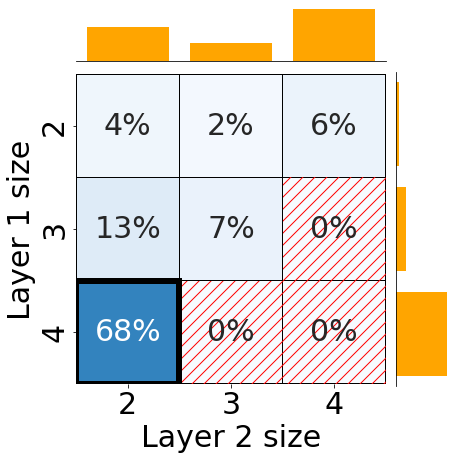

In [ ]:
iteration = -1

fontsize = 30
fontsize_annot = 30

unconditional_sampling_probs_all_choices_rejection_end = np.full((len(layer_1_choices), len(layer_2_choices)), np.nan)
feasible_prob = 0
for i_layer_1_choice, layer_1_choice in enumerate(layer_1_choices):
 for i_layer_2_choice, layer_2_choice in enumerate(layer_2_choices):
   if (i_layer_1_choice, i_layer_2_choice) in feasible_indices:
     unconditional_sampling_probs_all_choices_rejection_end[i_layer_1_choice, i_layer_2_choice] = sampling_probs_all_layer_1[i_layer_1_choice, iteration] * sampling_probs_all_layer_2[i_layer_2_choice, iteration]
     feasible_prob += unconditional_sampling_probs_all_choices_rejection_end[i_layer_1_choice, i_layer_2_choice]
 
sampling_probs_all_choices_rejection_end = np.full((len(layer_1_choices), len(layer_2_choices)), np.nan)
for i_layer_1_choice, layer_1_choice in enumerate(layer_1_choices):
 for i_layer_2_choice, layer_2_choice in enumerate(layer_2_choices):
   if (i_layer_1_choice, i_layer_2_choice) in feasible_indices:
     sampling_probs_all_choices_rejection_end[i_layer_1_choice, i_layer_2_choice] = unconditional_sampling_probs_all_choices_rejection_end[i_layer_1_choice, i_layer_2_choice] / feasible_prob
   else:
     sampling_probs_all_choices_rejection_end[i_layer_1_choice, i_layer_2_choice] = 0

data = pd.DataFrame({'Layer 2 size': sampling_probs_all_layer_2[:, iteration],
                     'Layer 1 size': sampling_probs_all_layer_1[:, iteration],
                     })
g = sns.jointplot(data=data, x="Layer 2 size", y="Layer 1 size")
g.ax_marg_y.cla()
g.ax_marg_x.cla()

annot_2d = [["" for _ in range(len(layer_2_choices))] for _ in range(len(layer_1_choices))]

for index_layer_1, layer_1_choice in enumerate(layer_1_choices):
  for index_layer_2, layer_2_choice in enumerate(layer_2_choices):
    annot_2d[index_layer_1][index_layer_2] = "{:.0%}".format(np.around(sampling_probs_all_choices_rejection_end, 2)[index_layer_1][index_layer_2])

sns.heatmap(sampling_probs_all_choices_rejection_end, annot=annot_2d, fmt='', linewidth=0.5, 
            ax=g.ax_joint, square=True, cmap='Blues', cbar=False, linewidths=2, linecolor='black', annot_kws={"fontsize": fontsize_annot}, vmin=0, vmax=1)
g.ax_joint.add_patch(Rectangle((1, 2), 1, 1, hatch=r"//", fill=False, edgecolor=edgecolor, lw=0))
g.ax_joint.add_patch(Rectangle((2, 1), 1, 1, hatch=r"//", fill=False, edgecolor=edgecolor, lw=0))
g.ax_joint.add_patch(Rectangle((2, 2), 1, 1, hatch=r"//", fill=False, edgecolor=edgecolor, lw=0))

g.ax_marg_y.barh(np.arange(0.5, len(layer_1_choices)), sampling_probs_all_layer_1[:, iteration], color='orange')
g.ax_marg_x.bar(np.arange(0.5, len(layer_2_choices)), sampling_probs_all_layer_2[:, iteration], color='orange')

g.ax_joint.add_patch(Rectangle(np.unravel_index(np.argmax(np.around(sampling_probs_all_choices_rejection_end, 2)), (len(layer_1_choices), len(layer_2_choices)))[::-1], 
                               1, 1, fill=False, edgecolor='black', lw=edge_lw))

g.ax_marg_x.tick_params(axis='x', bottom=False, labelbottom=False)
g.ax_marg_y.tick_params(axis='y', left=False, labelleft=False)
g.ax_marg_x.tick_params(axis='y', left=False, labelleft=False)
g.ax_marg_y.tick_params(axis='x', bottom=False, labelbottom=False)

g.ax_joint.set_xticks(np.arange(0.5, len(layer_2_choices)))
g.ax_joint.set_xticklabels(layer_2_choices, fontsize=fontsize)
g.ax_joint.set_yticks(np.arange(0.5, len(layer_1_choices)))
g.ax_joint.set_yticklabels(layer_1_choices, fontsize=fontsize)

g.ax_joint.set_xlabel('Layer 2 size', fontsize=fontsize)
g.ax_joint.set_ylabel('Layer 1 size', fontsize=fontsize)

filename = 'toy_example_mc_pvalid_sampling_prob_heatmap_lr_{}_{}_end.png'.format(rl_learning_rate, optimizer_name)
plt.savefig(filename, bbox_inches='tight')

# Hyperparameter tuning

RL with the Abs Reward

In [ ]:
# run RL with custom \beta
def run_abs_with_custom_beta(kwargs):
  i_rep, beta = kwargs
  # print('i_rep: ', i_rep, ', beta: ', beta)
  layer_1_probs_all = {} # key: number of steps
  layer_2_probs_all = {} # key: number of steps

  layer_1_logits = tf.Variable(tf.constant([0 for _ in range(len(layer_1_choices))], dtype=float))
  layer_2_logits = tf.Variable(tf.constant([0 for _ in range(len(layer_2_choices))], dtype=float))

  rl_reward_momentum = 0.9
  moving_average_baseline_numer = 0
  moving_average_baseline_denom = 0

  rl_advantage_all = []
  prob_valid_all = []

  for iter in range(max_iter):
    tf.random.set_seed(1000 * i_rep + iter)
    layer_1_dist = tfp.distributions.Categorical(logits=layer_1_logits)
    layer_1_probs = layer_1_dist.probs_parameter().numpy()
    index_layer_1_choice = layer_1_dist.sample().numpy()
    layer_1_choice = layer_1_choices[index_layer_1_choice]
    layer_2_dist = tfp.distributions.Categorical(logits=layer_2_logits)
    layer_2_probs = layer_2_dist.probs_parameter().numpy()
    index_layer_2_choice = layer_2_dist.sample().numpy()
    layer_2_choice = layer_2_choices[index_layer_2_choice]
    
    layer_1_probs_all[iter] = layer_1_probs
    layer_2_probs_all[iter] = layer_2_probs

    rl_reward = rewards[(layer_1_choice, layer_2_choice)] - beta * np.abs(get_parameter_number([layer_1_choice, layer_2_choice]) / get_parameter_number([3, 3]) - 1)
    moving_average_baseline_numer = rl_reward_momentum * moving_average_baseline_numer + (1 - rl_reward_momentum) * rl_reward
    moving_average_baseline_denom = rl_reward_momentum * moving_average_baseline_denom + 1 - rl_reward_momentum
    moving_average_baseline = moving_average_baseline_numer / moving_average_baseline_denom
    rl_advantage = rl_reward - moving_average_baseline 
    rl_advantage_all.append(rl_advantage)

    layer_1_logits_tf = layer_1_dist.logits
    layer_2_logits_tf = layer_2_dist.logits

    with tf.GradientTape(persistent=True) as tape:
        tape.watch(layer_1_logits_tf)
        tape.watch(layer_2_logits_tf)
        layer_1_probs_tf = tf.nn.softmax(layer_1_logits_tf)
        layer_2_probs_tf = tf.nn.softmax(layer_2_logits_tf)
        sampling_prob = layer_1_probs_tf[index_layer_1_choice] * layer_2_probs_tf[index_layer_2_choice]
        log_sampling_prob = tf.math.log(sampling_prob)
        negative_value_function = - rl_advantage * log_sampling_prob

    grad_layer_1 = tape.gradient(negative_value_function, layer_1_logits_tf)
    grad_layer_2 = tape.gradient(negative_value_function, layer_2_logits_tf)

    optimizer.apply_gradients(zip([grad_layer_1, grad_layer_2], [layer_1_logits, layer_2_logits]))

  layer_1_dist = tfp.distributions.Categorical(logits=layer_1_logits)
  layer_1_probs = layer_1_dist.probs_parameter().numpy()
  layer_2_dist = tfp.distributions.Categorical(logits=layer_2_logits)
  layer_2_probs = layer_2_dist.probs_parameter().numpy()
  layer_1_probs_all[max_iter] = layer_1_probs
  layer_2_probs_all[max_iter] = layer_2_probs

  return layer_1_probs_all, layer_2_probs_all

In [ ]:
# to-tune NAS hyperparameters
beta_all = np.linspace(0, 10, 51)
kwargs_all = list(product(np.arange(n_reps), beta_all))

# fixed NAS hyperparameters
rl_learning_rate = 0.05
max_iter = 500
optimizer_name = 'adam'

if optimizer_name == 'adam':
  optimizer = tf.keras.optimizers.Adam(learning_rate=rl_learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-8)

In [ ]:
n_reps = 20  # for easier demonstration; was 500 in paper
n_cpus = mp.cpu_count()
p = mp.Pool(n_cpus)
mp_results = [p.apply_async(run_abs_with_custom_beta, args=[kwarg]) for kwarg in kwargs_all]
r = [f.get() for f in mp_results]

layer_1_probs_all_in_all_reps = {}
layer_2_probs_all_in_all_reps = {}

for i, (i_rep, beta) in enumerate(kwargs_all):
  layer_1_probs_all_in_all_reps[(i_rep, beta)] = r[i][0]
  layer_2_probs_all_in_all_reps[(i_rep, beta)] = r[i][1]

In [ ]:
result_is_feasible = {}
result_is_optimal = {}
for beta in beta_all:
  for i_rep in range(n_reps):
    num_samples_for_postprocessing = 50

    layer_1_dist = tfp.distributions.Categorical(probs=layer_1_probs_all_in_all_reps[(i_rep, beta)][500])
    layer_2_dist = tfp.distributions.Categorical(probs=layer_2_probs_all_in_all_reps[(i_rep, beta)][500])

    index_layer_1_samples_for_mc = tf.cast(layer_1_dist.sample(num_samples_for_postprocessing), tf.int64).numpy()
    index_layer_2_samples_for_mc = tf.cast(layer_2_dist.sample(num_samples_for_postprocessing), tf.int64).numpy()

    final_choices = list(zip(index_layer_1_samples_for_mc, index_layer_2_samples_for_mc))

    if len(set(final_choices).intersection(set(feasible_indices))) > 0:
      result_is_feasible[(i_rep, beta)] = 1
    else:
      result_is_feasible[(i_rep, beta)] = 0

    if (2, 0) in set(final_choices):
      result_is_optimal[(i_rep, beta)] = 1
    else:
      result_is_optimal[(i_rep, beta)] = 0


In [ ]:
result_is_feasible_across_beta_mean = np.array([np.mean([result_is_feasible[(i_rep, beta)] for i_rep in range(n_reps)]) for beta in beta_all])
result_is_feasible_across_beta_std = np.array([np.std([result_is_feasible[(i_rep, beta)] for i_rep in range(n_reps)]) for beta in beta_all])
result_is_optimal_across_beta_mean = np.array([np.mean([result_is_optimal[(i_rep, beta)] for i_rep in range(n_reps)]) for beta in beta_all])
result_is_optimal_across_beta_std = np.array([np.std([result_is_optimal[(i_rep, beta)] for i_rep in range(n_reps)]) for beta in beta_all])

In [ ]:
fontsize = 50
colors = [plt.get_cmap('tab20')(0), plt.get_cmap('tab20')(4),  plt.get_cmap('tab20')(2)] # blue, green, red
# colors = ['red', 'green', 'blue']
linewidth = 8
linestyles = ['-', '--', '-.']
legend_pos = (1.2, 1)
alpha = 1
loc_legend = (.65, -1.8)

fig, ax = plt.subplots(figsize=(4, 3))
plt.rc('font', size=fontsize)
fig.patch.set_facecolor('white')
ax.set_xlabel('|β|', fontsize=fontsize)
ax.set_ylabel('probability', fontsize=fontsize)

ci_single = result_is_feasible_across_beta_std

ax.plot(beta_all, result_is_feasible_across_beta_mean, 
        linewidth=linewidth, color=colors[0], linestyle=linestyles[0], label='finding a feasible \n architecture', alpha=alpha)
ax.fill_between(beta_all, (result_is_feasible_across_beta_mean-result_is_feasible_across_beta_std), 
                (result_is_feasible_across_beta_mean+result_is_feasible_across_beta_std), color=colors[0], alpha=.3, linewidth=0)


ax.plot(beta_all, result_is_optimal_across_beta_mean, label='finding the best\n in feasible set',
        linewidth=linewidth, color=colors[1], linestyle=linestyles[0], alpha=alpha)
ax.fill_between(beta_all, (result_is_optimal_across_beta_mean-result_is_optimal_across_beta_std), 
                (result_is_optimal_across_beta_mean+result_is_optimal_across_beta_std), color=colors[1], alpha=.3, linewidth=0)

plt.ylim(-0.01, 1.01)
plt.xlim(0, 10)
plt.xticks([0, 10], fontsize=fontsize)
plt.yticks([0, 1], fontsize=fontsize)
filename = 'beta_tuning.pdf'
plt.savefig(filename, bbox_inches='tight')

leg = plt.legend(loc='center', bbox_to_anchor=loc_legend, handlelength=1.2, ncol=1, fontsize=fontsize-13, frameon=True, framealpha=0.4)
for legobj in leg.legendHandles:
  legobj.set_linewidth(10.0)

def export_legend(legend, expand=[-5,-5,5,5]):
  fig  = legend.figure
  fig.canvas.draw()
  bbox  = legend.get_window_extent()
  bbox = bbox.from_extents(*(bbox.extents + np.array(expand)))
  bbox = bbox.transformed(fig.dpi_scale_trans.inverted())
  fig.savefig("hyperparameter_tuning_legend.pdf", bbox_inches=bbox)
  
export_legend(leg)

RL with the rejection-based reward

In [ ]:
optimizer_name = 'adam'
rl_learning_rate = 0.1
max_iter = 500

def run_sampling_with_custom_N(kwargs):
  i_rep, num_samples_for_mc = kwargs

  if optimizer_name == 'adam':
    optimizer = tf.keras.optimizers.Adam(learning_rate=rl_learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-8)

  layer_1_probs_all = {} # key: number of steps
  layer_2_probs_all = {} # key: number of steps

  layer_1_logits = tf.Variable(tf.constant([0 for _ in range(len(layer_1_choices))], dtype=float))
  layer_2_logits = tf.Variable(tf.constant([0 for _ in range(len(layer_2_choices))], dtype=float))

  rl_reward_momentum = 0.9
  moving_average_baseline_numer = 0
  moving_average_baseline_denom = 0

  rl_advantage_all = []
  prob_valid_all = []

  for iter in range(max_iter):
    tf.random.set_seed(1000 * i_rep + iter)
    
    index_layer_1_choice = -1
    index_layer_2_choice = -1
    while (index_layer_1_choice, index_layer_2_choice) not in feasible_indices:
      layer_1_dist = tfp.distributions.Categorical(logits=layer_1_logits)
      layer_1_probs = layer_1_dist.probs_parameter().numpy()
      index_layer_1_choice = layer_1_dist.sample().numpy()
      layer_1_choice = layer_1_choices[index_layer_1_choice]
      layer_2_dist = tfp.distributions.Categorical(logits=layer_2_logits)
      layer_2_probs = layer_2_dist.probs_parameter().numpy()
      index_layer_2_choice = layer_2_dist.sample().numpy()
      layer_2_choice = layer_2_choices[index_layer_2_choice]
    
    layer_1_probs_all[iter] = layer_1_probs
    layer_2_probs_all[iter] = layer_2_probs

    moving_average_baseline_numer = rl_reward_momentum * moving_average_baseline_numer + (1 - rl_reward_momentum) * rewards[(layer_1_choice, layer_2_choice)]
    moving_average_baseline_denom = rl_reward_momentum * moving_average_baseline_denom + 1 - rl_reward_momentum
    moving_average_baseline = moving_average_baseline_numer / moving_average_baseline_denom
    rl_advantage = rewards[(layer_1_choice, layer_2_choice)] - moving_average_baseline
    rl_advantage_all.append(rl_advantage)

    layer_1_logits_tf = layer_1_dist.logits
    layer_2_logits_tf = layer_2_dist.logits

    with tf.GradientTape(persistent=True) as tape:
        tape.watch(layer_1_logits_tf)
        tape.watch(layer_2_logits_tf)
        layer_1_probs_tf = tf.nn.softmax(layer_1_logits_tf)
        layer_2_probs_tf = tf.nn.softmax(layer_2_logits_tf)
        index_layer_1_samples_for_mc = tf.cast(layer_1_dist.sample(num_samples_for_mc), tf.int64).numpy()
        index_layer_2_samples_for_mc = tf.cast(layer_2_dist.sample(num_samples_for_mc), tf.int64).numpy()
        sampled_feasible_choices = [(index_layer_1_single, index_layer_2_single) for index_layer_1_single, index_layer_2_single in zip(index_layer_1_samples_for_mc, index_layer_2_samples_for_mc) \
                                    if (index_layer_1_single, index_layer_2_single) in feasible_indices]
        if len(sampled_feasible_choices) == 0:
          continue
        estimated_prob_valid = tf.reduce_sum([layer_1_probs_tf[i] * layer_2_probs_tf[j] for i, j in sampled_feasible_choices])
        conditional_prob = layer_1_probs_tf[index_layer_1_choice] * layer_2_probs_tf[index_layer_2_choice] / estimated_prob_valid
        log_conditional_prob = tf.math.log(conditional_prob)
        negative_value_function = - rl_advantage * log_conditional_prob

    grad_layer_1 = tape.gradient(negative_value_function, layer_1_logits_tf)
    grad_layer_2 = tape.gradient(negative_value_function, layer_2_logits_tf)

    optimizer.apply_gradients(zip([grad_layer_1, grad_layer_2], [layer_1_logits, layer_2_logits]))


  layer_1_dist = tfp.distributions.Categorical(logits=layer_1_logits)
  layer_1_probs = layer_1_dist.probs_parameter().numpy()
  layer_2_dist = tfp.distributions.Categorical(logits=layer_2_logits)
  layer_2_probs = layer_2_dist.probs_parameter().numpy()
  layer_1_probs_all[max_iter] = layer_1_probs
  layer_2_probs_all[max_iter] = layer_2_probs

  return layer_1_probs_all, layer_2_probs_all

In [ ]:
# NAS hyperparameters
N_all = [i for i in range(1, 11)]
N_all = np.array(N_all).astype(int)
kwargs_all = list(product(np.arange(n_reps), N_all))

# fixed hyperparameters
rl_learning_rate = 0.1
max_iter = 500
optimizer_name = 'adam'

if optimizer_name == 'adam':
  optimizer = tf.keras.optimizers.Adam(learning_rate=rl_learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-8)

In [ ]:
n_reps = 20  # for easier demonstration; was 500 in paper
n_cpus = mp.cpu_count()
p = mp.Pool(n_cpus)
mp_results = [p.apply_async(run_sampling_with_custom_N, args=[kwarg]) for kwarg in kwargs_all]
r = [f.get() for f in mp_results]

layer_1_probs_all_in_all_reps = {}
layer_2_probs_all_in_all_reps = {}

for i, (i_rep, N) in enumerate(kwargs_all):
  layer_1_probs_all_in_all_reps[(i_rep, N)] = r[i][0]
  layer_2_probs_all_in_all_reps[(i_rep, N)] = r[i][1]

In [ ]:
result_is_feasible = {}
result_is_optimal = {}

for N in N_all:
  for i_rep in range(n_reps):  
    # for sampling
    num_samples_for_postprocessing = 50

    layer_1_dist = tfp.distributions.Categorical(probs=layer_1_probs_all_in_all_reps[(i_rep, N)][500])
    layer_2_dist = tfp.distributions.Categorical(probs=layer_2_probs_all_in_all_reps[(i_rep, N)][500])

    index_layer_1_samples_for_mc = tf.cast(layer_1_dist.sample(num_samples_for_postprocessing), tf.int64).numpy()
    index_layer_2_samples_for_mc = tf.cast(layer_2_dist.sample(num_samples_for_postprocessing), tf.int64).numpy()

    final_choices = list(zip(index_layer_1_samples_for_mc, index_layer_2_samples_for_mc))
    final_feasible_choices = [item for item in final_choices if item in feasible_indices]

    if len(set(final_choices).intersection(set(feasible_indices))) > 0:
      result_is_feasible[(i_rep, N)] = 1
    else:
      result_is_feasible[(i_rep, N)] = 0

    if (2, 0) in set(final_choices):
      result_is_optimal[(i_rep, N)] = 1
    else:
      result_is_optimal[(i_rep, N)] = 0

In [ ]:
result_is_feasible_across_beta_mean = np.array([np.mean([result_is_feasible[(i_rep, N)] for i_rep in range(n_reps)]) for N in N_all])
result_is_feasible_across_beta_std = np.array([np.std([result_is_feasible[(i_rep, N)] for i_rep in range(n_reps)]) for N in N_all])
result_is_optimal_across_beta_mean = np.array([np.mean([result_is_optimal[(i_rep, N)] for i_rep in range(n_reps)]) for N in N_all])
result_is_optimal_across_beta_std = np.array([np.std([result_is_optimal[(i_rep, N)] for i_rep in range(n_reps)]) for N in N_all])

In [ ]:
fontsize = 50
colors = [plt.get_cmap('tab20')(0), plt.get_cmap('tab20')(4),  plt.get_cmap('tab20')(2)] # blue, green, red
linewidth = 8
linestyles = ['-', '--', '-.']
legend_pos = (1.2, 1)
alpha = 1
loc_legend = (.65, -1.8)


fig, ax = plt.subplots(figsize=(4, 3))
plt.rc('font', size=fontsize)
fig.patch.set_facecolor('white')
ax.set_xlabel('N', fontsize=fontsize)
ax.set_ylabel('probability', fontsize=fontsize)

ci_single = result_is_feasible_across_beta_std

ax.plot(N_all, result_is_feasible_across_beta_mean, 
        linewidth=linewidth, color=colors[0], linestyle=linestyles[0], label='finding a feasible \n architecture', alpha=alpha)
ax.fill_between(N_all, (result_is_feasible_across_beta_mean-result_is_feasible_across_beta_std), 
                (result_is_feasible_across_beta_mean+result_is_feasible_across_beta_std), color=colors[0], alpha=.3, linewidth=0)


ax.plot(N_all, result_is_optimal_across_beta_mean, label='finding the best\n in feasible set',
        linewidth=linewidth, color=colors[1], linestyle=linestyles[0], alpha=alpha)
ax.fill_between(N_all, (result_is_optimal_across_beta_mean-result_is_optimal_across_beta_std), 
                (result_is_optimal_across_beta_mean+result_is_optimal_across_beta_std), color=colors[1], alpha=.3, linewidth=0)

plt.xticks([1, 9], fontsize=fontsize)
plt.ylim(-0.01, 1.01)
plt.xlim(1, 9)
plt.yticks([0, 1], fontsize=fontsize)
filename = 'N_tuning.pdf'
plt.savefig(filename, bbox_inches='tight')